In [1]:
import numpy as np
from scipy.stats import multivariate_normal, norm, t
import matplotlib.pyplot as plt

# Define the copula's density

### Gaussian copula
The two dimensional Gaussian copula is 
$$ C_\rho(u,v) = \Phi_\rho(\Phi^{-1}(u),\Phi^{-1}(v)), $$
where $\Phi_\rho$ is the 2-dim standard normal distribution with corrlation $\rho$,and $\Phi$ is the 1-dim standard normal distribution. And the density of Gauss copula is 
$$ \begin{aligned}
		c(u,v;\rho)&=\frac{1}{\phi(x)\phi(y)}\frac{1}{2\pi\sqrt{1-\rho^2}}\exp\{-\frac{x^2+y^2-2\rho xy}{2(1-\rho^2)}\} \\
		& = \frac{1}{\sqrt{1-\rho^2}} \exp\{\frac{2\rho xy -\rho^2(x^2+y^2)}{2(1-\rho^2)}\}
	\end{aligned}, $$
where $x=\Phi^{-1}(u),y=\Phi^{-1}(u_2)$ and $\phi$ is the density of 1-dim standard normal distribution.

In [2]:
def gau_cop_density(u, rho):
    mask = (u[:,0] == 0) | (u[:,1] == 0) | (u[:,0]==1) | (u[:,1]==1)
    pdf_values = np.zeros(u.shape[0])
    x = norm.ppf(u[~mask])
    x,y = x[...,0], x[...,1]
    a = 1 / np.sqrt(1-rho**2)
    b = (2*rho*x*y - rho**2*(x**2+y**2))/(2*(1-rho**2))
    # print(a*np.e**b)
    # print(pdf_values)
    pdf_values[~mask] = a*np.e**b
    return pdf_values

In [3]:
u = np.array([[0.2,0.5], [0.6,0.9], [0,0.1]])
# gau_cop_density(u, rho)

### Clayton copula

The two dimensional Clayton copula is 
$$ C(u,v;\theta) = [\max(u^{-\theta}+v^{-\theta}-1, 0)]^{-1/\theta}, \quad\theta\in[-1,\infty)\textbackslash \{0\}.$$
The density is
$$ c(u,v;\theta) = (1+\theta)u^{-\theta-1}v^{-\theta-1}[\max(u^{-\theta}+v^{-\theta}-1,0)]^{-\frac{1}{\theta} -2}. $$

In [4]:
def clay_cop_density(u, theta):
    mask = (u[:,0] == 0) | (u[:,1] == 0) | (u[:,0]==1) | (u[:,1]==1)
    pdf_values = np.zeros(u.shape[0])
    u, v = u[~mask,...,0], u[~mask,...,1]
    max_term = np.maximum(u**(-theta) + v**(-theta) - 1, 0)
    pdf_values[~mask] = (1+theta) * (u*v)**(-theta-1) * max_term**(-1/theta-2)
    return pdf_values

#### Covariance matrix and derived parameters

In [5]:
mu = np.array([0,0])
cova_matr = np.array([[1, 0.3], [0.3, 1]])
rho = cova_matr[0,1] / np.sqrt(cova_matr[0,0] * cova_matr[1,1])

#### Plot 3D surface of the multivariate normal density

In [6]:
x1 = np.arange(-4, 4.2, 0.2)
x2 = np.arange(-4, 4.2, 0.2)
X1, X2 = np.meshgrid(x1, x2)
pos = np.dstack((X1, X2))
F = multivariate_normal(mean=mu, cov=cova_matr).pdf(pos)

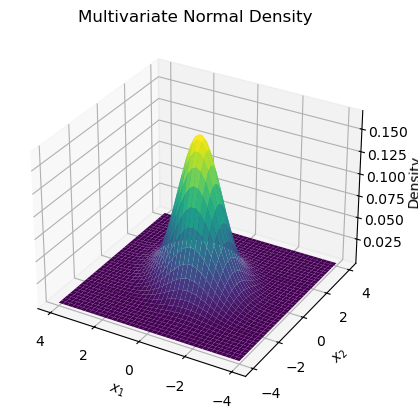

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, F, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('Density')
ax.set_title('Multivariate Normal Density')
ax.invert_xaxis()
plt.show()

#### Marginal distributions

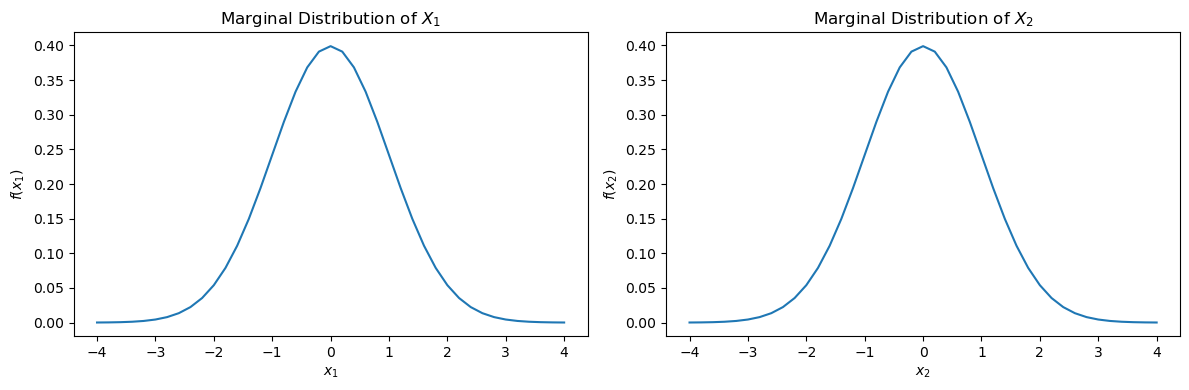

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(x1, norm.pdf(x1, loc=mu[0], scale=np.sqrt(cova_matr[0, 0])))
axs[0].set_title('Marginal Distribution of $X_1$')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$f(x_1)$')

axs[1].plot(x2, norm.pdf(x2, loc=mu[1], scale=np.sqrt(cova_matr[1, 1])))
axs[1].set_title('Marginal Distribution of $X_2$')
axs[1].set_xlabel('$x_2$')
axs[1].set_ylabel('$f(x_2)$')

plt.tight_layout()
plt.show()

#### Plot Gaussian Copula density

In [9]:
u1 = np.linspace(0, 1, 100)
u2 = np.linspace(0, 1, 100)
U1, U2 = np.meshgrid(u1, u2)

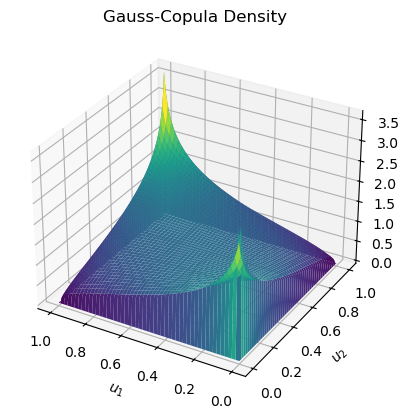

In [10]:
y = gau_cop_density(np.array([U1.ravel(), U2.ravel()]).T, rho)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U1, U2, y.reshape(U1.shape), cmap='viridis')
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.invert_xaxis()
ax.set_title('Gauss-Copula Density')
plt.show()

#### Multivariate density

From Skalr's formula, $ F(x,y) = C(F_X(x), F_Y(y)) $, we have that the density of joint distribution can be expressed as
$$f(x,y) = c(F_X(x),F_Y(y))f_X(x)f_Y(y),$$
or let $x=F_X^{-1}(u)$ and $v=F_Y^{-1}(v)$,
we have
$$ f(F_X^{-1}(u),F_Y^{-1}(v)) = c(u,v)f_X(F_X^{-1}(u))f_Y^{-1}(F_Y^{-1}(v)) $$

For $C$ is Gauss copula, and $F_X, F_Y$ are normal distribution:

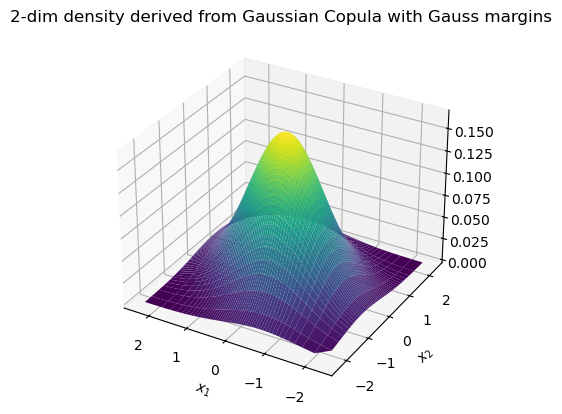

In [11]:
y = gau_cop_density(np.array([U1.ravel(), U2.ravel()]).T, rho)

f_mv = np.zeros(U1.shape)
X1_inv = np.zeros(U1.shape)
X2_inv = np.zeros(U1.shape)

for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        X1_inv[i, j] = norm.ppf(U1[i, j], loc=mu[0], scale=np.sqrt(cova_matr[0, 0]))
        X2_inv[i, j] = norm.ppf(U2[i, j], loc=mu[1], scale=np.sqrt(cova_matr[1, 1]))
        f_mv[i, j] = norm.pdf(X1_inv[i, j], loc=mu[0], scale=np.sqrt(cova_matr[0, 0])) * \
                     norm.pdf(X2_inv[i, j], loc=mu[1], scale=np.sqrt(cova_matr[1, 1])) * \
                     y[i * U1.shape[1] + j]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_inv, X2_inv, f_mv, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.invert_xaxis()
ax.set_title('2-dim density derived from Gaussian Copula with Gauss margins')
plt.show()

For $C$ is Gauss copula, and $F_X, F_Y$ are t-distribution:

In [12]:
nu1 = 10  # Degrees of freedom for t-distribution of X1
nu2 = 20  # Degrees of freedom for t-distribution of X2
rho_t = 0.34
y_t = gau_cop_density(np.array([U1.ravel(), U2.ravel()]).T, rho_t)

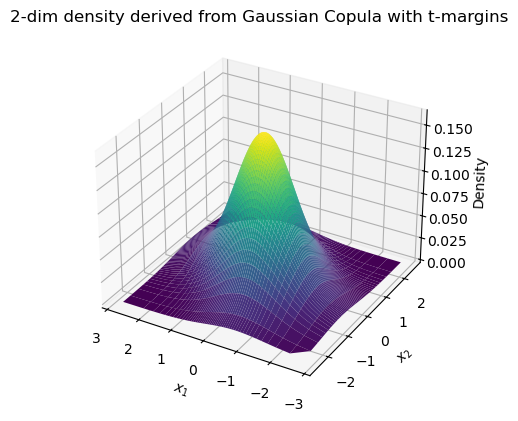

In [13]:
f_mv_t = np.zeros(U1.shape)
X1_inv_t = np.zeros(U1.shape)
X2_inv_t = np.zeros(U1.shape)

for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        X1_inv_t[i, j] = t.ppf(U1[i, j], df=nu1)
        X2_inv_t[i, j] = t.ppf(U2[i, j], df=nu2)
        f_mv_t[i, j] = t.pdf(X1_inv_t[i, j], df=nu1) * \
                       t.pdf(X2_inv_t[i, j], df=nu2) * \
                       y_t[i * U1.shape[1] + j]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_inv_t, X2_inv_t, f_mv_t, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.invert_xaxis()
ax.set_zlabel('Density')
ax.set_title('2-dim density derived from Gaussian Copula with t-margins')
plt.show()

#### Plot Clayton density

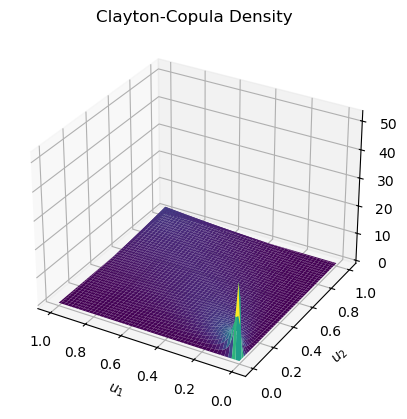

In [14]:
theta = 2
y = clay_cop_density(np.array([U1.ravel(), U2.ravel()]).T, theta)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(U1, U2, y.reshape(U1.shape), cmap='viridis')
ax.set_xlabel('$u_1$')
ax.set_ylabel('$u_2$')
ax.invert_xaxis()
ax.set_title('Clayton-Copula Density')
plt.show()

For $C$ is Clayton copula, and $F_X, F_Y$ are normal distribution:

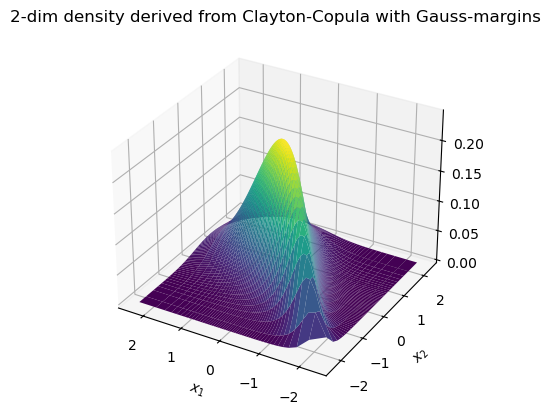

In [15]:
y = clay_cop_density(np.array([U1.ravel(), U2.ravel()]).T, theta)

f_mv = np.zeros(U1.shape)
X1_inv = np.zeros(U1.shape)
X2_inv = np.zeros(U1.shape)

for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        X1_inv[i, j] = norm.ppf(U1[i, j], loc=mu[0], scale=np.sqrt(cova_matr[0, 0]))
        X2_inv[i, j] = norm.ppf(U2[i, j], loc=mu[1], scale=np.sqrt(cova_matr[1, 1]))
        f_mv[i, j] = norm.pdf(X1_inv[i, j], loc=mu[0], scale=np.sqrt(cova_matr[0, 0])) * \
                     norm.pdf(X2_inv[i, j], loc=mu[1], scale=np.sqrt(cova_matr[1, 1])) * \
                     y[i * U1.shape[1] + j]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_inv, X2_inv, f_mv, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.invert_xaxis()
ax.set_title('2-dim density derived from Clayton-Copula with Gauss-margins')
plt.show()

For $C$ is Clayton copula, and $F_X, F_Y$ are t-distribution:

In [16]:
nu1 = 10  # Degrees of freedom for t-distribution of X1
nu2 = 20  # Degrees of freedom for t-distribution of X2
rho_t = 0.34
y_t = clay_cop_density(np.array([U1.ravel(), U2.ravel()]).T, theta)

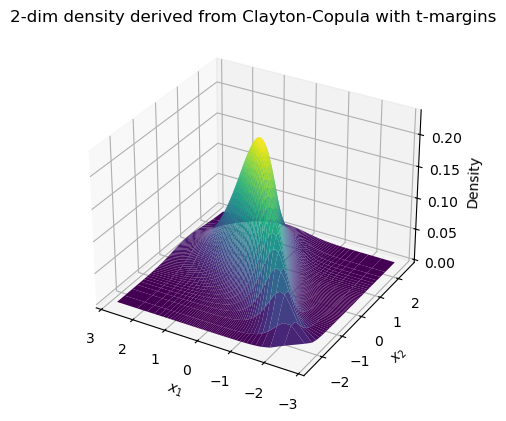

In [17]:
f_mv_t = np.zeros(U1.shape)
X1_inv_t = np.zeros(U1.shape)
X2_inv_t = np.zeros(U1.shape)

for i in range(U1.shape[0]):
    for j in range(U1.shape[1]):
        X1_inv_t[i, j] = t.ppf(U1[i, j], df=nu1)
        X2_inv_t[i, j] = t.ppf(U2[i, j], df=nu2)
        f_mv_t[i, j] = t.pdf(X1_inv_t[i, j], df=nu1) * \
                       t.pdf(X2_inv_t[i, j], df=nu2) * \
                       y_t[i * U1.shape[1] + j]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1_inv_t, X2_inv_t, f_mv_t, cmap='viridis')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.invert_xaxis()
ax.set_zlabel('Density')
ax.set_title('2-dim density derived from Clayton-Copula with t-margins')
plt.show()